# Data Preparation for training models

## Getting Data from RDS

In [1]:
import pymysql
import pandas as pd
import numpy as np
import math
import pickle
import os
import sys
sys.path.append("..")

from config import *
config = MainConfig()

In [2]:
conn = pymysql.connect(
    host=config.DB_SERVER,
    port=int(config.DB_PORT),
    user=config.DB_USER,
    passwd=config.DB_PASSWORD,
    db=config.DB_NAME,
    charset='utf8mb4')

In [3]:
df_station_updates = pd.read_sql_query(
    "SELECT * FROM dublin_bikes.station_updates;",
    conn)
df_station_updates.head(10)

,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow
0,2,20,10,10,2021-02-27 17:35:14,Clouds,9.34,75.0,2.57,0.0,0.0
1,2,20,10,10,2021-02-27 17:45:23,Clouds,9.20,75.0,1.03,0.0,0.0
2,2,20,10,10,2021-02-27 17:55:32,Clouds,9.48,75.0,1.03,0.0,0.0
3,2,20,11,9,2021-02-27 18:00:42,Clouds,9.22,75.0,1.03,0.0,0.0
4,2,20,11,9,2021-02-27 18:10:51,Clouds,8.85,75.0,0.51,0.0,0.0
5,2,20,11,9,2021-02-27 18:20:59,Clouds,8.76,75.0,0.51,0.0,0.0
6,2,20,11,9,2021-02-27 18:31:08,Clouds,8.52,75.0,0.51,0.0,0.0
7,2,20,11,9,2021-02-27 18:41:17,Clouds,8.17,75.0,1.03,0.0,0.0
8,2,20,11,9,2021-02-27 18:51:25,Clouds,8.26,75.0,2.06,0.0,0.0
9,2,20,11,9,2021-02-27 19:01:34,Clouds,8.01,75.0,1.03,0.0,0.0


In [4]:
df_station_updates.shape

(664337, 11)

### Duplicates

In [5]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', df_station_updates.duplicated().sum())

# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', df_station_updates[df_station_updates.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


### Cardinalities & Unique Values

In [6]:
# Number of unique values for all features (ignores null values)
df_station_updates.nunique()

stationId            110
totalStands           18
availableBikes        41
freeStands            41
lastUpdate        458083
mainWeather            7
temperature         1769
cloudiness            16
windSpeed             67
rain                 359
snow                  10
dtype: int64

In [7]:
# check unique values for categorical features (to compare against dummies created later)
df_station_updates['mainWeather'].unique()

array(['Clouds', 'Fog', 'Mist', 'Clear', 'Rain', 'Drizzle', 'Snow'],
      dtype=object)

### Dropping stationId=507

In [8]:
# check how many rows per station
# station with Id 507 was added much later by JCDecaux so there's a big difference in the number of rows there
df_station_updates['stationId'].value_counts(dropna=False)

69     5925
34     5789
33     5684
31     5679
5      5650
       ... 
117    5163
65     5155
15     5119
96     4931
507     291
Name: stationId, Length: 110, dtype: int64

In [9]:
df_station_updates.loc[df_station_updates['stationId'] == 507]

,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow
586132,507,1,1,0,2021-03-26 12:05:20,Clouds,6.39,20.0,9.26,0.0,0.0
586133,507,1,0,1,2021-03-26 12:10:52,Clouds,6.38,20.0,9.26,0.0,0.0
586134,507,1,0,1,2021-03-26 12:20:58,Clouds,6.46,20.0,6.69,0.0,0.0
586135,507,1,0,1,2021-03-26 12:32:39,Clouds,6.25,20.0,6.69,0.0,0.0
586136,507,1,0,1,2021-03-26 12:42:45,Clouds,6.83,40.0,6.69,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
586418,507,1,0,1,2021-03-28 12:55:47,Clouds,14.53,75.0,9.26,0.0,0.0
586419,507,1,1,0,2021-03-28 13:06:21,Clouds,14.71,75.0,9.26,0.0,0.0
586420,507,1,1,0,2021-03-28 13:13:37,Clouds,14.55,75.0,9.77,0.0,0.0
586421,507,1,0,1,2021-03-28 13:19:57,Clouds,14.72,75.0,9.77,0.0,0.0


In [10]:
# checked below while calculating average availability that station 507 is missing some days/hours which could cause problems
# drop rows with stationId 507 since availability is either 1 or 0 and there is no data for some weekdays hours
df_station_updates = df_station_updates[df_station_updates.stationId != 507]

In [11]:
# check rows were dropped
df_station_updates.loc[df_station_updates['stationId'] == 507]

,stationId,totalStands,availableBikes,freeStands,lastUpdate,mainWeather,temperature,cloudiness,windSpeed,rain,snow


In [12]:
df_station_updates.shape

(586132, 11)

In [13]:
# check number of stations - looks correct, there were 109 stations before station with Id 507 was added by JCDecaux later on
df_station_updates['stationId'].nunique()

109

## Features Engineering

In [14]:
df_station_updates.dtypes

stationId                  int64
totalStands                int64
availableBikes             int64
freeStands                 int64
lastUpdate        datetime64[ns]
mainWeather               object
temperature              float64
cloudiness               float64
windSpeed                float64
rain                     float64
snow                     float64
dtype: object

In [15]:
# stationId into type 'object'
df_station_updates['stationId'] = df_station_updates['stationId'].astype('object')

### Adding weekday feature

In [16]:
# series.dt.dayofweek attribute returns a numpy array containing the day of the week of the DateTime variable with Monday = 0 & Sunday = 6
df_station_updates['weekday'] = df_station_updates['lastUpdate'].dt.day_name()
df_station_updates[['lastUpdate','weekday']].head()

,lastUpdate,weekday
0,2021-02-27 17:35:14,Saturday
1,2021-02-27 17:45:23,Saturday
2,2021-02-27 17:55:32,Saturday
3,2021-02-27 18:00:42,Saturday
4,2021-02-27 18:10:51,Saturday


**Encoding categorical features with `get_dummies`**

In [17]:
weekday_dummies = pd.get_dummies(df_station_updates['weekday'], prefix='weekday', drop_first=True)
print("Weekday Dummies:", weekday_dummies)

Weekday Dummies:         weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
0                    0                 1               0                 0   
1                    0                 1               0                 0   
2                    0                 1               0                 0   
3                    0                 1               0                 0   
4                    0                 1               0                 0   
...                ...               ...             ...               ...   
586127               0                 0               0                 0   
586128               0                 0               0                 0   
586129               0                 0               0                 0   
586130               0                 0               0                 0   
586131               0                 0               0                 0   

        weekday_Tuesday  weekday_Wednesday  
0

In [18]:
df_station_updates['weekday'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Wednesday', 'Thursday', 'Friday',
       'Tuesday'], dtype=object)

### Adding fullHour feature

In [19]:
df_station_updates['fullHour'] = df_station_updates['lastUpdate'].dt.hour
df_station_updates[['lastUpdate','fullHour']].head()    

,lastUpdate,fullHour
0,2021-02-27 17:35:14,17
1,2021-02-27 17:45:23,17
2,2021-02-27 17:55:32,17
3,2021-02-27 18:00:42,18
4,2021-02-27 18:10:51,18


**Since `fullHour` is cyclical data we need to transform that feature so that it will be interpreted that way by the model**

- transform feature fullHour in features:
    - sin_hour --> sin(hour)
    - cos_hour --> cos(hour)

In [20]:
df_station_updates['hour_sin'] = np.sin(2 * np.pi * df_station_updates['fullHour']/23.0)
df_station_updates['hour_cos'] = np.cos(2 * np.pi * df_station_updates['fullHour']/23.0)

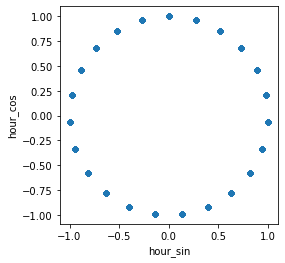

In [21]:
# check with a scatter plot of the two new features if the encoding is correct
df_station_updates.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

### Encoding MainWeather

In [22]:
mainWeather_dummies = pd.get_dummies(df_station_updates['mainWeather'], prefix='mainWeather', drop_first=True)
print("Main Weather Dummies:", mainWeather_dummies)

Main Weather Dummies:         mainWeather_Clouds  mainWeather_Drizzle  mainWeather_Fog  \
0                        1                    0                0   
1                        1                    0                0   
2                        1                    0                0   
3                        1                    0                0   
4                        1                    0                0   
...                    ...                  ...              ...   
586127                   1                    0                0   
586128                   1                    0                0   
586129                   1                    0                0   
586130                   1                    0                0   
586131                   1                    0                0   

        mainWeather_Mist  mainWeather_Rain  mainWeather_Snow  
0                      0                 0                 0  
1                      0           

### Preparing features for training

In [23]:
# Continous features for training
cont_features = ['temperature', 'cloudiness', 'windSpeed', 'rain', 'snow', 'hour_sin', 'hour_cos']

In [24]:
# Categorical features for training
categ_features = weekday_dummies.columns.values.tolist() + mainWeather_dummies.columns.values.tolist()
categ_features

['weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'mainWeather_Clouds',
 'mainWeather_Drizzle',
 'mainWeather_Fog',
 'mainWeather_Mist',
 'mainWeather_Rain',
 'mainWeather_Snow']

In [25]:
# add all features together
all_features = cont_features + categ_features
print("\nCont features: ", cont_features)
print("Categ features: ", categ_features)
print("Features: ", all_features)


Cont features:  ['temperature', 'cloudiness', 'windSpeed', 'rain', 'snow', 'hour_sin', 'hour_cos']
Categ features:  ['weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'mainWeather_Clouds', 'mainWeather_Drizzle', 'mainWeather_Fog', 'mainWeather_Mist', 'mainWeather_Rain', 'mainWeather_Snow']
Features:  ['temperature', 'cloudiness', 'windSpeed', 'rain', 'snow', 'hour_sin', 'hour_cos', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'mainWeather_Clouds', 'mainWeather_Drizzle', 'mainWeather_Fog', 'mainWeather_Mist', 'mainWeather_Rain', 'mainWeather_Snow']


### Creating features lists

In [26]:
# get all station Ids in a list
station_id_list = df_station_updates['stationId'].unique().tolist()
print(station_id_list)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]


In [27]:
# doublecheck hours - looks good, 24 different full hours
# get hours in list sorted --> used to calculate average availability below
full_hour_list = df_station_updates['fullHour'].value_counts().index.sort_values().tolist()
print(full_hour_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [28]:
# get weekdays in list --> used to calculate average availability below
weekdays_list = df_station_updates['weekday'].value_counts().index.tolist()
print(weekdays_list)

['Sunday', 'Monday', 'Saturday', 'Tuesday', 'Friday', 'Wednesday', 'Thursday']


### Store feature lists to open in other notebook

In [29]:
%store categ_features cont_features all_features station_id_list full_hour_list weekdays_list

Stored 'categ_features' (list)
Stored 'cont_features' (list)
Stored 'all_features' (list)
Stored 'station_id_list' (list)
Stored 'full_hour_list' (list)
Stored 'weekdays_list' (list)


### Finalise dataframe with new and encoded features

In [30]:
# add encoded features to dataframe
df_station_updates_all_features = pd.get_dummies(df_station_updates, columns=['mainWeather', 'weekday'], drop_first=True)

In [31]:
df_station_updates_all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586132 entries, 0 to 586131
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   stationId            586132 non-null  object        
 1   totalStands          586132 non-null  int64         
 2   availableBikes       586132 non-null  int64         
 3   freeStands           586132 non-null  int64         
 4   lastUpdate           586132 non-null  datetime64[ns]
 5   temperature          586132 non-null  float64       
 6   cloudiness           586132 non-null  float64       
 7   windSpeed            586132 non-null  float64       
 8   rain                 586132 non-null  float64       
 9   snow                 586132 non-null  float64       
 10  fullHour             586132 non-null  int64         
 11  hour_sin             586132 non-null  float64       
 12  hour_cos             586132 non-null  float64       
 13  mainWeather_Cl

In [32]:
df_station_updates_all_features.head(10)

,stationId,totalStands,availableBikes,freeStands,lastUpdate,temperature,cloudiness,windSpeed,rain,snow,...,mainWeather_Fog,mainWeather_Mist,mainWeather_Rain,mainWeather_Snow,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2,20,10,10,2021-02-27 17:35:14,9.34,75.0,2.57,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,2,20,10,10,2021-02-27 17:45:23,9.20,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,2,20,10,10,2021-02-27 17:55:32,9.48,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,2,20,11,9,2021-02-27 18:00:42,9.22,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,2,20,11,9,2021-02-27 18:10:51,8.85,75.0,0.51,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
5,2,20,11,9,2021-02-27 18:20:59,8.76,75.0,0.51,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
6,2,20,11,9,2021-02-27 18:31:08,8.52,75.0,0.51,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
7,2,20,11,9,2021-02-27 18:41:17,8.17,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
8,2,20,11,9,2021-02-27 18:51:25,8.26,75.0,2.06,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
9,2,20,11,9,2021-02-27 19:01:34,8.01,75.0,1.03,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


### Save dataframe as pickle file

In [33]:
filename = 'df_station_updates_all_features'
outfile = open(filename, 'wb')
pickle.dump(df_station_updates_all_features,outfile)
outfile.close()